Kaye Ng and Vivian Uy's submission for Programming Assessment #4

INTRNLP S17

## remove this afterwards!

********
### Data

You may follow the procedure done in the Python notebook if you're not sure what to do.

Study the data and understand what you have before moving to techniques.

The dataset to be used is a smaller version and only contains the sentiment (positive, neutral, negative), the airline in question (Virgin America and US Airways), and the text from the tweet.

There are 3,462 tweets in total. Its up to you how you understand the corpus and how its structure might affect the eventual learning model.


### Pre-process + Feature Extraction

Use at least 3 different feature extraction techniques out of, but not limited to, the following:
1. Term counts
2. Term frequency
3. Term frequency inverse document frequency
4. POS tags
5. Word sense counts
6. Word sense frequency
7. Sentiment-related features

You're expected to test out different parameters (e.g. # of POS tags, min/max document frequency) for each. It would be nice to report these, but you may stick with the best parameters based on experiments.
You may or may not perform pre-processing / cleaning, but you must talk about the effects of processing the data or leaving it raw.
1. Can preprocessing help in the boasting the accuracy?
2. Is the way you're tokenizing affecting the output?
3. Look at things before the learning bit and craft features that might contain loads of information for the classifier.


### Machine Learning

Limit yourselves to Naive Bayes. You are free to use other ML algorithms, but kindly just use one and focus on the effect of the techniques.
Kindly measure accuracy and F1 score (F-measure) for each model for comparison.
For simplicity, you can just do a single train and test split (like how the Python notebook shows).

There is a lot of room for you to do your thing here, but again, you are to focus on experimenting with different data pre-processing techniques and feature extraction methods. Don't overdo it and just focus on complying with the specs of the assignment. If you want to experiment with more, feel free to do so. :)

Please also use tools, like those from ScikitLearn or NLTK. Don't stress yourselves out doing too much. Search for implementations of the techniques.

You are also to create a write-up. Write all your observations, queries, comments, violent reactions, whatever. Which features did best/worst? Does it make sense that the best/worst features performed in such a manner? Was the dataset even good in the first place? The write-up has heavier weight than the program, so despite the program, focus on experimentation and note everything down.

### Importing packages

In [1]:
import pandas as pd
import nltk
import numpy as np
import html
import re
from autocorrect import spell

from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet

from sklearn.model_selection import train_test_split

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer #, HashingVectorizer
# from sklearn.naive_bayes import MultinomialNB
# from sklearn.pipeline import Pipeline
# from sklearn.metrics import roc_curve, auc

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
# setting up a default plot style

def defaultPlotting():
    sns.set(rc={'figure.figsize': (12, 6)})
    sns.set_context("talk", rc={"font.size": 20, "axes.titlesize": 18, "axes.labelsize": 18})
    plt.rcParams['axes.spines.bottom'] = False
    plt.rcParams['axes.spines.top'] = False
    plt.rcParams['axes.spines.left'] = False
    plt.rcParams['axes.spines.right'] = False
    plt.rcParams['axes.labelsize'] = 16
    plt.rcParams['axes.labelweight'] = 'bold'
    plt.rcParams['axes.titlesize'] = 16
    plt.rcParams['xtick.labelsize'] = 14
    plt.rcParams['ytick.labelsize'] = 14
    plt.rcParams['legend.fontsize'] = 14
    plt.rcParams['figure.titlesize'] = 24
    
defaultPlotting()

In [3]:
import csv

slang_dict = {}
contractions = {}

def load_dictionary(dictionary, filename):
    with open(filename, "r") as myCSVfile:
        # Reading file as CSV with delimiter as "=", so that abbreviation are stored in row[0] and phrases in row[1]
        dataFromFile = csv.reader(myCSVfile, delimiter="=")

        for row in dataFromFile:
            dictionary[row[0].lower()] = row[1].lower()

        myCSVfile.close()

load_dictionary(slang_dict, "data/slang.txt")
load_dictionary(contractions, "data/contractions.txt")

In [4]:
from nltk.tokenize import TweetTokenizer
tokenizer = TweetTokenizer(preserve_case=False, strip_handles=True)

def tokenize_text(tweet):
    return tokenizer.tokenize(tweet)

In [5]:
pattern = re.compile(r"(\b[-'.]\b)|[\W_]")

def remove_punct(doc):
    return pattern.sub(lambda m: (m.group(1) if m.group(1) else " "), doc)

In [6]:
def reduce_word(word):
    p = re.compile(r"(.)\1{2,}")
    return p.sub(r"\1\1", word)

In [7]:
# from https://stackoverflow.com/a/46564234

class LemmatizationWithPOSTagger(object):
    def __init__(self):
        pass
    
    def get_wordnet_pos(self, treebank_tag):
        """
        return WORDNET POS compliance to WORDNET lemmatization (a,n,r,v) 
        """
        if treebank_tag.startswith('J'):
            return wordnet.ADJ
        elif treebank_tag.startswith('V'):
            return wordnet.VERB
        elif treebank_tag.startswith('N'):
            return wordnet.NOUN
        elif treebank_tag.startswith('R'):
            return wordnet.ADV
        else:
            # default pos in lemmatization is noun
            return wordnet.NOUN

## todo: use stanfordcorenlp POS tagger

In [8]:
def preprocess(word):
     # spell check --- slow
    word = spell(word)

    # get pos
    tag = nltk.pos_tag([word])[0][1]
#     print(word, tag)
    
    #filter out non-verbs, non-adjectives and non-adverbs & lemmatize
    if tag.startswith('V') or tag.startswith('J') or tag.startswith('R'):
#         print('inside if')
        return WordNetLemmatizer().lemmatize(word.strip().replace(".", ""),
                                      pos=LemmatizationWithPOSTagger().get_wordnet_pos(
                                                        tag))
    
    return ""

In [9]:
def tokenize_tweet(tweet):
    tokenize = tokenize_text(tweet)

    cleaned = []
    for token in tokenize:
        
        if token[0] != '#':
            cleaned_token = reduce_word(token)
            cleaned_token = remove_punct(cleaned_token)
            
            # expand slang/acronym
            if cleaned_token in slang_dict.keys():
#                 print('slang found:', '\t', slang_dict[cleaned_token])
                for word in slang_dict[cleaned_token].split():
                    cleaned_token = preprocess(word)
                    if cleaned_token.strip() != "":
                        cleaned.append(cleaned_token)
                    
            elif cleaned_token in contractions.keys():
#                 print('contraction found:', '\t', contractions[cleaned_token])
                
                for word in contractions[cleaned_token].split():
                    cleaned_token = preprocess(word)
                    if cleaned_token.strip() != "":
                        cleaned.append(cleaned_token)
                    
            else:
                cleaned.append(preprocess(cleaned_token))


    return ' '.join(cleaned).strip()

In [10]:
tokenize_tweet('hello I am MIA')

'be miss'

### Reading and inspecting the data

In [11]:
pd.set_option('display.max_colwidth', -1)

In [12]:
df = pd.read_csv('data/Virgin America and US Airways Tweets.csv', sep='\t')

In [13]:
df.head()

,airline_sentiment,airline,text
0,neutral,Virgin America,@VirginAmerica What @dhepburn said.
1,positive,Virgin America,@VirginAmerica plus you've added commercials to the experience... tacky.
2,neutral,Virgin America,@VirginAmerica I didn't today... Must mean I need to take another trip!
3,negative,Virgin America,"@VirginAmerica it's really aggressive to blast obnoxious ""entertainment"" in your guests' faces &amp; they have little recourse"
4,negative,Virgin America,@VirginAmerica and it's a really big bad thing about it


### Understanding the corpus

In [14]:
df.shape

(3417, 3)

In [15]:
df.describe(include='all')

,airline_sentiment,airline,text
count,3417,3417,3417
unique,3,2,3409
top,negative,US Airways,@USAirways thank you
freq,2444,2913,3


In [16]:
df.isnull().sum()

airline_sentiment    0
airline              0
text                 0
dtype: int64

In [17]:
df.airline_sentiment.value_counts()

negative    2444
neutral     552 
positive    421 
Name: airline_sentiment, dtype: int64

In [18]:
pct = ((df.airline_sentiment.value_counts() / df.airline_sentiment.count()) * 100)

pct

negative    71.524729
neutral     16.154522
positive    12.320749
Name: airline_sentiment, dtype: float64

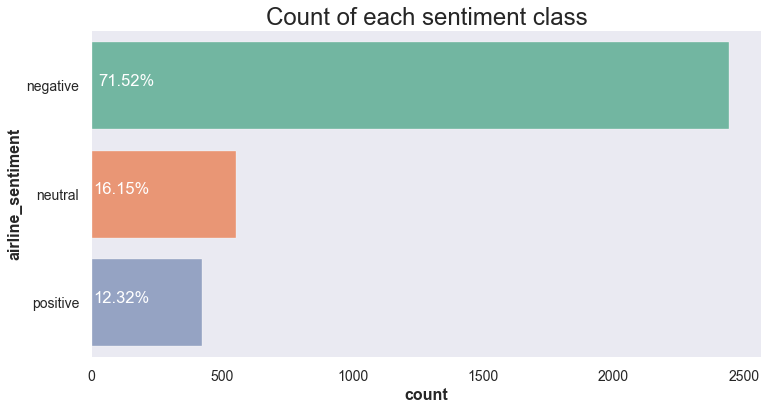

In [19]:
ax = sns.countplot(y="airline_sentiment", data=df, palette="Set2", linewidth=0.3,
                   order = df.airline_sentiment.value_counts().index)

for i, p in enumerate(ax.patches):
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy()
    ax.annotate('{0:.2f}%'.format(pct[i]), (p.get_x() + 0.01 * width, p.get_y() + .45 * height), 
                color='white', ha='left', va='center', fontsize='small')

plt.title('Count of each sentiment class', fontsize=24)
    
plt.grid(False)

In [20]:
# Total words per class

def count_words(nArray):
    punct = '!"#$%&\'()*+,-./:;<=>?@[\\]^_`{}~'
    transtab = str.maketrans(dict.fromkeys(punct, ''))

    word_count = 0
    for sentence in nArray:
        tokens = nltk.word_tokenize(sentence.translate(transtab))
        
        # the translate portion just removed the punctuation
        word_count += len(tokens)

    return word_count

In [21]:
print("Total words in negative tweets:", count_words(df.loc[df.airline_sentiment == 'negative'].text.values))

Total words in negative tweets: 48095


In [23]:
print("Total words in neutral tweets:", count_words(df.loc[df.airline_sentiment == 'neutral'].text.values))

Total words in neutral tweets: 8327


In [24]:
print("Total words in positive tweets:", count_words(df.loc[df.airline_sentiment == 'positive'].text.values))

Total words in positive tweets: 5928


In [25]:
df.iloc[3413].text

'.@USAirways we have no choice but to pay another $50 to go to the airport in the hopes that we will be treated better by a rep.'

In [29]:
nltk.pos_tag(['better'])

[('better', 'RBR')]

### Pre-processing the text

In [88]:
df.iloc[5].text

"@VirginAmerica seriously would pay $30 a flight for seats that didn't have this playing.\nit's really the only bad thing about flying VA"

In [89]:
df['text'] = df['text'].apply(lambda x: x.replace("\n", " "))

In [90]:
df.iloc[5].text

"@VirginAmerica seriously would pay $30 a flight for seats that didn't have this playing. it's really the only bad thing about flying VA"

In [91]:
df.iloc[3].text

'@VirginAmerica it\'s really aggressive to blast obnoxious "entertainment" in your guests\' faces &amp; they have little recourse'

In [92]:
df['text'] = df['text'].apply(lambda x: html.unescape(x))

In [93]:
df.iloc[3].text

'@VirginAmerica it\'s really aggressive to blast obnoxious "entertainment" in your guests\' faces & they have little recourse'

In [94]:
df.head()

,airline_sentiment,airline,text
0,neutral,Virgin America,@VirginAmerica What @dhepburn said.
1,positive,Virgin America,@VirginAmerica plus you've added commercials to the experience... tacky.
2,neutral,Virgin America,@VirginAmerica I didn't today... Must mean I need to take another trip!
3,negative,Virgin America,"@VirginAmerica it's really aggressive to blast obnoxious ""entertainment"" in your guests' faces & they have little recourse"
4,negative,Virgin America,@VirginAmerica and it's a really big bad thing about it


**Problem**: how to convert symbols (incl. emoji) into words?

Example:

In [95]:
df.iloc[11].text

'@VirginAmerica I <3 pretty graphics. so much better than minimal iconography. :D'

<3 --> 'love' ?

**Problem**: typos

Example:

In [96]:
df.iloc[182].text

'@VirginAmerica Flight from BOS > LAS tomorrow was Cancelled Flightled. No notification; wait times are 1+ hour. Will you rebook on another airline?'

In [97]:
nltk.pos_tag(['look'])

[('look', 'NN')]

In [98]:
df.iloc[3399].text

"@USAirways @AmericanAir you make Spirit look like the gem of air travel. You haven't handle this winter storm very well..."

In [102]:
%%time

df.text = df.text.apply(lambda tweet: tokenize_tweet(tweet))
df.head()

CPU times: user 6min 4s, sys: 9.01 s, total: 6min 13s
Wall time: 6min 16s


In [105]:
df.head()

,airline_sentiment,airline,text
0,neutral,Virgin America,say
1,positive,Virgin America,have add
2,neutral,Virgin America,do not take
3,negative,Virgin America,be really aggressive obnoxious face have little
4,negative,Virgin America,be really big bad


In [103]:
df.tail(20)

,airline_sentiment,airline,text
3397,negative,US Airways,soon be possible board be be now be be still start
3398,negative,US Airways,be down other
3399,negative,US Airways,make have not very well
3400,positive,US Airways,hop be clear up
3401,negative,US Airways,take
3402,negative,US Airways,file be late still find
3403,negative,US Airways,be suppose be come be
3404,neutral,US Airways,soon possible
3405,negative,US Airways,even get someone-awesome
3406,negative,US Airways,almost now high be unacceptable


### Splitting into training and testing sets

In [104]:
Y = df.airline_sentiment
X = df.text

X_train, X_test, Y_train, Y_test = train_test_split(
    X, # Features
    Y, # Labels
    test_size = 0.3, # The defined test size; Training size is just 1 minus the test size
    random_state = 12 # So we can shuffle the elements, but with some consistency
)

print("=====\nTraining Data")
print("Document count: %s" % len(Y_train))
labels, counts = np.unique(Y_train, return_counts=True)
for label, count in zip(labels, counts):
    print("%s: %s (%.4f)" % (label, count, count/len(Y_train)))
        
print("=====\nTesting Data")
print("Document count: %s" % len(Y_test))
labels, counts = np.unique(Y_test, return_counts=True)
for label, count in zip(labels, counts):
    print("%s: %s (%.4f)" % (label, count, count/len(Y_test)))

=====
Training Data
Document count: 2391
negative: 1712 (0.7160)
neutral: 392 (0.1639)
positive: 287 (0.1200)
=====
Testing Data
Document count: 1026
negative: 732 (0.7135)
neutral: 160 (0.1559)
positive: 134 (0.1306)


### Undersampling

In [47]:
Y_train.value_counts()

negative    1712
neutral     392 
positive    287 
Name: airline_sentiment, dtype: int64

Random under-sampling:
negative    287
neutral     287
positive    287
Name: airline_sentiment, dtype: int64


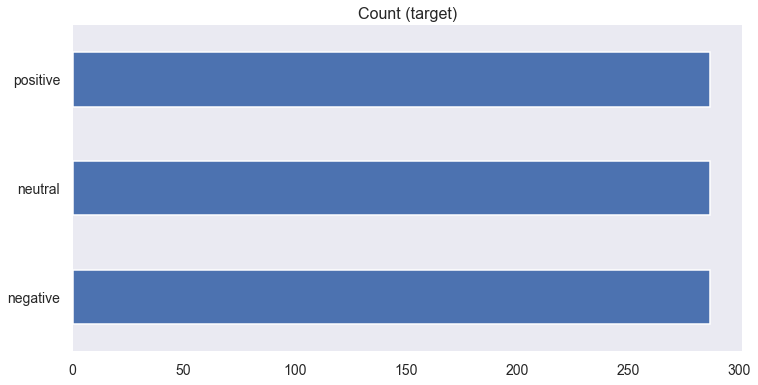

In [48]:
count_class_0, count_class_1, count_class_2 = Y_train.value_counts()

# Divide by class
df_class_0 = Y_train[Y_train  == 'negative']
df_class_1 = Y_train[Y_train  == 'neutral']
df_class_2 = Y_train[Y_train  == 'positive']

df_class_0_under = df_class_0.sample(count_class_2)
df_class_1_under = df_class_1.sample(count_class_2)
df_test_under = pd.concat([df_class_0_under, df_class_1_under, df_class_2], axis=0)

print('Random under-sampling:')
print(df_test_under.value_counts())

df_test_under.value_counts().plot(kind='barh', title='Count (target)')
plt.grid(False)

In [49]:
X_train = pd.concat([df.iloc[df_class_0_under.index].text, df.iloc[df_class_1_under.index].text, 
                    df.iloc[df_class_2.index].text])
# X_train
# df.iloc[df_class_0_under.index].text
Y_train = df_test_under

### Extracting features from text

### Training the models

## OLD

### Adding class weights

In [ ]:
from sklearn.preprocessing import LabelBinarizer
# y = LabelBinarizer().fit_transform(y)
# y.sum(axis=0)

In [133]:
from sklearn.utils import class_weight

class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(y_train),
                                                 y_train)

class_weights

array([0.46256529, 2.10846561, 2.74827586])

In [ ]:
# clfs = [
# #     KNeighborsClassifier(n_neighbors=5),
#     MultinomialNB(),
# #     svm.SVC(kernel='linear')
# ]

# for clf in clfs:
#     clf.fit(X_train, Y_train)
#     y_pred = clf.predict(X_test)
#     acc = accuracy_score(Y_test, y_pred)
#     f1 = f1_score(Y_test, y_pred, average=None)
# #     auc = roc_auc_score(Y_test, y_pred)
#     auc = 0

#     print("%s\nAccuracy: %s\nF1 Score: %s\nAUC: %s\n=====" % (clf, acc, f1, auc))

In [31]:
from stanfordcorenlp import StanfordCoreNLP
nlp = StanfordCoreNLP('http://localhost', port=9000)

pos_set = {}
def add_to_pos_set(sentence):
    pos_set.update(dict(nlp.pos_tag(pattern.sub(lambda m: (m.group(1) if m.group(1) else " "),
                                           sentence))))

In [32]:
def tokenize_tweet(doc):
    cleaned = []
    tokenize = tokenize_text(doc)

    for token in tokenize:

        if not token.startswith(("#", "http")):

            cleaned_token = remove_punct(token)
            cleaned_token = reduce_word(cleaned_token)

            if cleaned_token in slang_dict.keys():
                for word in slang_dict[cleaned_token].split():
                    if word.strip() != "":
                        cleaned.append(word)
                        
            elif cleaned_token in contractions.keys():
                for word in contractions[cleaned_token].split():
                    if word.strip() != "":
                        cleaned.append(word)

            else:
                cleaned.append(get_correct_spelling(cleaned_token))
    
    return ' '.join(cleaned).strip()

In [33]:
from tqdm import tqdm
tqdm.pandas()

df.text = df.text.progress_apply(lambda tweet: tokenize_tweet(tweet))

100%|██████████| 3417/3417 [00:03<00:00, 1059.53it/s]


In [34]:
df.text.progress_map(lambda x: add_to_pos_set(x))

# Store data (serialize)
with open('pos_tag_corpus.pickle', 'wb') as handle:
    pickle.dump(pos_set, handle, protocol=pickle.HIGHEST_PROTOCOL)

100%|██████████| 3417/3417 [00:39<00:00, 85.73it/s] 


In [35]:
sorted(pos_set.items())

[("'", '``'),
 ("'s", 'POS'),
 ('.', '.'),
 ('0', 'CD'),
 ('00', 'CD'),
 ('01', 'NN'),
 ('0316', 'CD'),
 ('03723890474', 'CD'),
 ('0400', 'CD'),
 ('05', 'CD'),
 ('07', 'CD'),
 ('0736', 'CD'),
 ('0769', 'CD'),
 ('1', 'CD'),
 ('1-2', 'CD'),
 ('1-800', 'CD'),
 ('1.00', 'CD'),
 ('1.5', 'CD'),
 ('10', 'CD'),
 ('10-24', 'CD'),
 ('100', 'CD'),
 ('100cost', 'IN'),
 ('1030', 'CD'),
 ('11', 'CD'),
 ('112', 'CD'),
 ('1137', 'CD'),
 ('12', 'CD'),
 ('12.45', 'CD'),
 ('120', 'CD'),
 ('1200', 'CD'),
 ('1217', 'CD'),
 ('1230', 'CD'),
 ('125', 'CD'),
 ('13', 'CD'),
 ('130', 'CD'),
 ('138', 'CD'),
 ('140', 'CD'),
 ('15', 'CD'),
 ('15-18', 'CD'),
 ('150', 'CD'),
 ('1500', 'CD'),
 ('150202-004', 'CD'),
 ('153.69', 'CD'),
 ('1581', 'CD'),
 ('16', 'CD'),
 ('167', 'CD'),
 ('17', 'CD'),
 ('1701', 'CD'),
 ('1707', 'CD'),
 ('1712', 'CD'),
 ('1715', 'CD'),
 ('1727', 'CD'),
 ('1729', 'CD'),
 ('1735', 'CD'),
 ('1748', 'CD'),
 ('1769', 'CD'),
 ('177', 'CD'),
 ('1773', 'CD'),
 ('1776', 'CD'),
 ('1783', 'CD'),
 ('179

*****

In [139]:
def tokenize_tweet(doc):
    cleaned = []
    tokenize = tokenize_text(doc)

    for token in tokenize:

        if token[0] != '#':
            cleaned_token = reduce_word(token)
            cleaned_token = remove_punct(cleaned_token)

            # expand slang/acronym
            if cleaned_token in slang_dict.keys():
#                 print('slang found:', '\t', slang_dict[cleaned_token])
                for word in slang_dict[cleaned_token].split():
                    cleaned_token = preprocess(word)
                    if cleaned_token.strip() != "":
                        cleaned.append(cleaned_token)

            elif cleaned_token in contractions.keys():
#                 print('contraction found:', '\t', contractions[cleaned_token])

                for word in contractions[cleaned_token].split():
                    cleaned_token = preprocess(word)
                    if cleaned_token.strip() != "":
                        cleaned.append(cleaned_token)

            else:
                cleaned.append(preprocess(cleaned_token))


    return [' '.join(cleaned).strip()]

tokenize_tweet('testing running crying')

['test run cry']